__Import Library__

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

1. Load Dataset & inspect

In [3]:
train_df = pd.read_csv('./dataset/new_train.csv')
test_df = pd.read_csv('./dataset/new_test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# print(train_df.head())

Train shape: (32950, 16)
Test shape: (8238, 13)


2. Convert target to 0/1

In [4]:
train_df['y'] = train_df['y'].map({'no': 0, 'yes': 1})

3. Define categorical and numeric columns

In [6]:
categorical_cols = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'month',
    'day_of_week', 'poutcome'
]

numeric_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous'
]

4. One-hot encode categorical columns

In [7]:
train_enc = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_enc  = pd.get_dummies(test_df,  columns=categorical_cols, drop_first=True)

# align test columns to train columns
test_enc = test_enc.reindex(columns=train_enc.drop('y', axis=1).columns, fill_value=0)

5. TRAIN/TEST SPLIT

In [8]:
from sklearn.utils import class_weight
import numpy as np

X = train_enc.drop('y', axis=1)
y = train_enc['y']

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
# print(X_train.head())

Train: (26360, 48)
Validation: (6590, 48)


6. SCALING

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(test_enc)

input_dim = X_train_scaled.shape[1]
print("Input features:", input_dim)

# Reshape for LSTM → (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], input_dim, 1))
X_val_lstm   = X_val_scaled.reshape((X_val_scaled.shape[0], input_dim, 1))

Input features: 48


### 7. ANN Model

In [11]:
early_stop_ann = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

model_ann = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_ann.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_ann = model_ann.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop_ann],
    verbose=1
)

ann_loss, ann_acc = model_ann.evaluate(X_val_scaled, y_val, verbose=0)
print(f"\nANN Accuracy: {ann_acc:.4f}")
print(f"ANN Loss: {ann_loss:.4f}\n")

Epoch 1/100
206/206 [==============================] - 3s 6ms/step - loss: 0.2928 - accuracy: 0.8867 - val_loss: 0.2232 - val_accuracy: 0.9012
Epoch 2/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2276 - accuracy: 0.9022 - val_loss: 0.2150 - val_accuracy: 0.9052
Epoch 3/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2191 - accuracy: 0.9037 - val_loss: 0.2145 - val_accuracy: 0.9049
Epoch 4/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2133 - accuracy: 0.9060 - val_loss: 0.2130 - val_accuracy: 0.9058
Epoch 5/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2106 - accuracy: 0.9064 - val_loss: 0.2138 - val_accuracy: 0.9052
Epoch 6/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2072 - accuracy: 0.9061 - val_loss: 0.2086 - val_accuracy: 0.9055
Epoch 7/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2055 - accuracy: 0.9094 - val_loss: 0.2089 - val_accuracy: 0.9058

__Import Library for confusion matrix, accuracy graph, loss graph__

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

8.1 Confusion Matrix for ANN

206/206 [==============================] - 0s 1ms/step


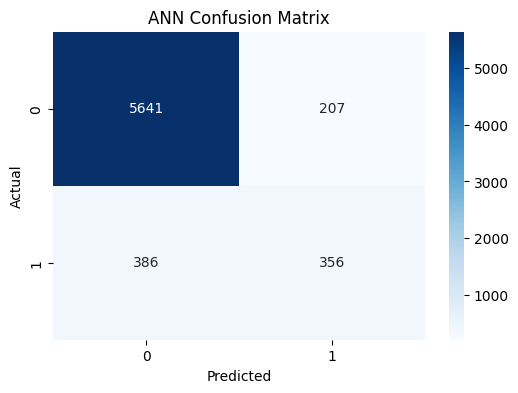

ANN Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5848
           1       0.63      0.48      0.55       742

    accuracy                           0.91      6590
   macro avg       0.78      0.72      0.75      6590
weighted avg       0.90      0.91      0.90      6590



In [32]:
# Predict classes on validation data
val_pred_ann = (model_ann.predict(X_val_scaled) >= 0.5).astype(int)

# Confusion matrix for ANN
cm_ann = confusion_matrix(y_val, val_pred_ann)

plt.figure(figsize=(6,4))
sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues")
plt.title("ANN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report (precision, recall, f1)
print("ANN Classification Report:\n")
print(classification_report(y_val, val_pred_ann))

8.2 Accuracy Graph (ANN)

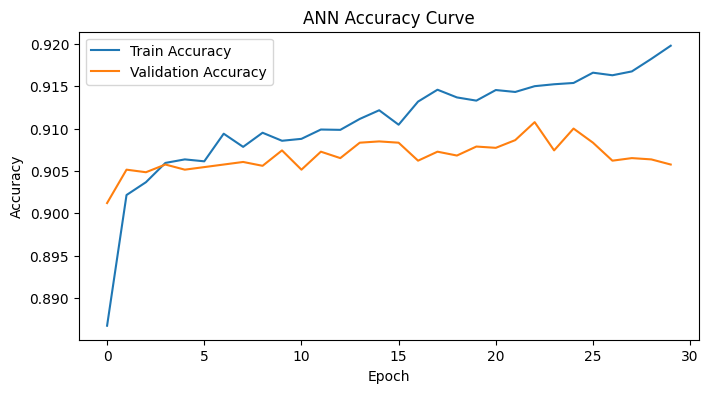

In [33]:
plt.figure(figsize=(8,4))
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title("ANN Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

8.3 Loss Graph (ANN)

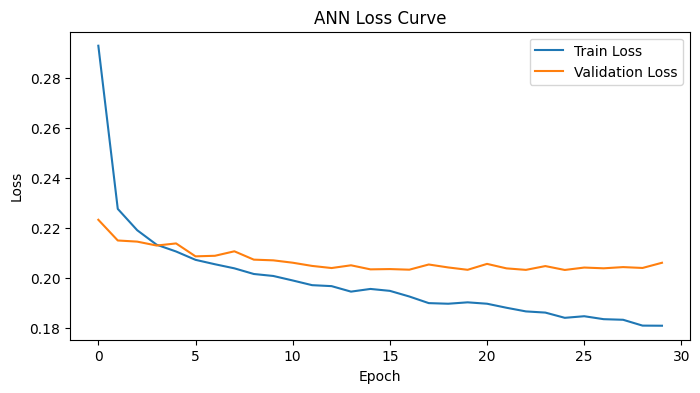

In [34]:
plt.figure(figsize=(8,4))
plt.plot(history_ann.history['loss'], label='Train Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title("ANN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 9. CNN MODEL: (1D CNN)

In [13]:
# reshape for CNN (samples, features, 1)
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], input_dim, 1))
X_val_cnn   = X_val_scaled.reshape((X_val_scaled.shape[0], input_dim, 1))
X_test_cnn  = X_test_scaled.reshape((X_test_scaled.shape[0], input_dim, 1))

early_stop_cnn = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

model_cnn = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn],
    verbose=1
)

cnn_loss, cnn_acc = model_cnn.evaluate(X_val_cnn, y_val, verbose=0)
print(f"\nCNN Accuracy: {cnn_acc:.4f}")
print(f"CNN Loss: {cnn_loss:.4f}\n")

Epoch 1/100
412/412 [==============================] - 7s 6ms/step - loss: 0.2699 - accuracy: 0.8970 - val_loss: 0.2492 - val_accuracy: 0.8986
Epoch 2/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2258 - accuracy: 0.9023 - val_loss: 0.2165 - val_accuracy: 0.9014
Epoch 3/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2180 - accuracy: 0.9044 - val_loss: 0.2192 - val_accuracy: 0.9046
Epoch 4/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2148 - accuracy: 0.9033 - val_loss: 0.2127 - val_accuracy: 0.9052
Epoch 5/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2130 - accuracy: 0.9046 - val_loss: 0.2121 - val_accuracy: 0.9053
Epoch 6/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2103 - accuracy: 0.9049 - val_loss: 0.2103 - val_accuracy: 0.9067
Epoch 7/100
412/412 [==============================] - 2s 6ms/step - loss: 0.2074 - accuracy: 0.9059 - val_loss: 0.2132 - val_accuracy: 0.9035

9.1 Confusion Matrix for CNN

206/206 [==============================] - 0s 2ms/step


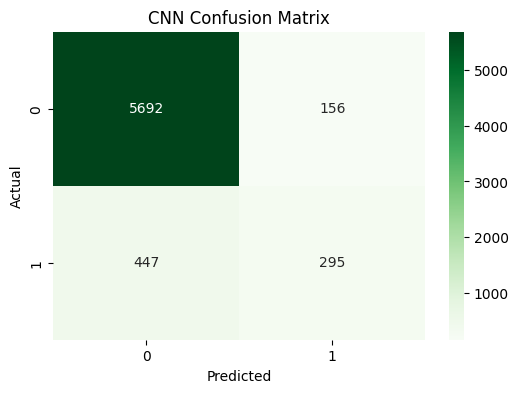

CNN Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5848
           1       0.65      0.40      0.49       742

    accuracy                           0.91      6590
   macro avg       0.79      0.69      0.72      6590
weighted avg       0.90      0.91      0.90      6590



In [35]:
val_pred_cnn = (model_cnn.predict(X_val_cnn) >= 0.5).astype(int)

cm_cnn = confusion_matrix(y_val, val_pred_cnn)

plt.figure(figsize=(6,4))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Greens")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("CNN Classification Report:\n")
print(classification_report(y_val, val_pred_cnn))

9.2 Accuracy Graph (CNN)

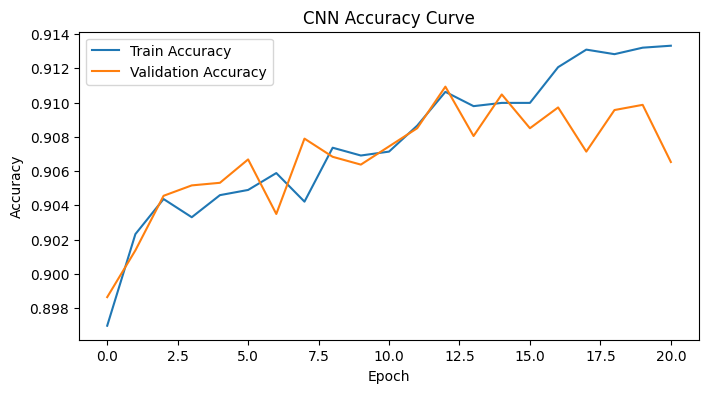

In [36]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

9.3 Loss Graph (CNN)

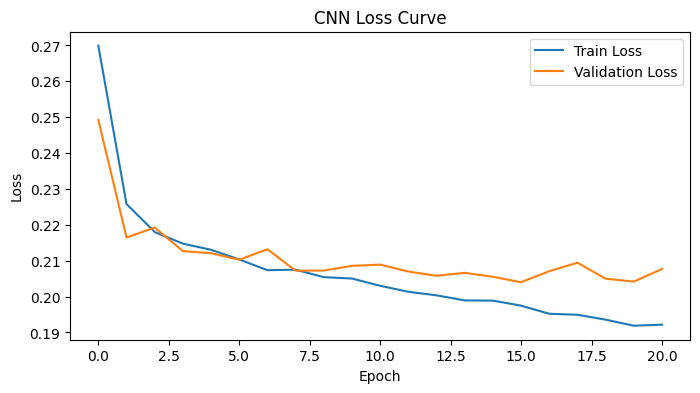

In [37]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 10. Build LSTM Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop_lstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(input_dim, 1)),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_lstm.summary()

history_lstm = model_lstm.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_lstm],
    verbose=1
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
412/412 [=============================

10.1 Evaluate LSTM

In [38]:
lstm_loss, lstm_acc = model_lstm.evaluate(X_val_lstm, y_val, verbose=0)
print(f"\nLSTM Accuracy: {lstm_acc:.4f}")
print(f"LSTM Loss: {lstm_loss:.4f}")



LSTM Accuracy: 0.8992
LSTM Loss: 0.2562


10.2 Confusion Matrix for LSTM

206/206 [==============================] - 1s 4ms/step


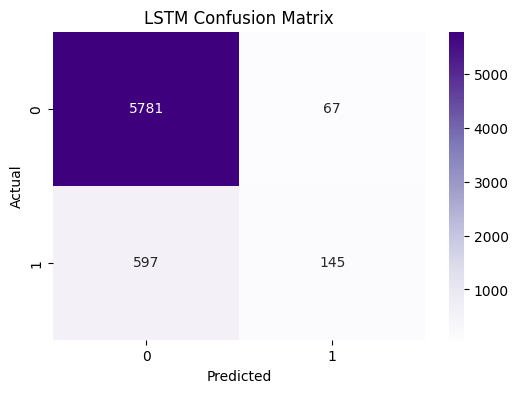


LSTM Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5848
           1       0.68      0.20      0.30       742

    accuracy                           0.90      6590
   macro avg       0.80      0.59      0.62      6590
weighted avg       0.88      0.90      0.87      6590



In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
val_pred_lstm = (model_lstm.predict(X_val_lstm) >= 0.5).astype(int)

# Confusion Matrix
cm_lstm = confusion_matrix(y_val, val_pred_lstm)

plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Purples")
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nLSTM Classification Report:\n")
print(classification_report(y_val, val_pred_lstm))


10.3 LSTM Accuracy Curve

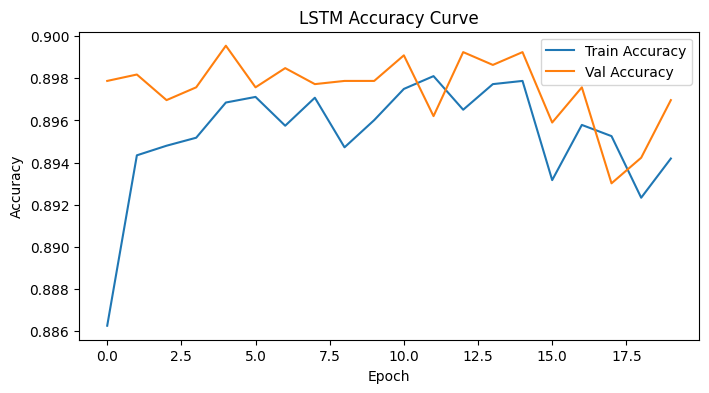

In [40]:
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title("LSTM Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


10.4 LSTM Loss Curve

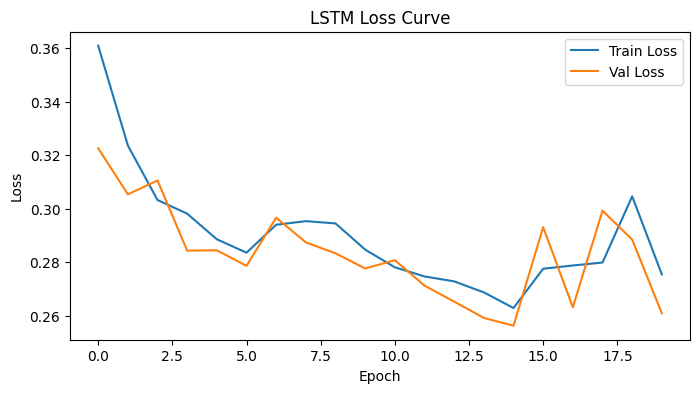

In [41]:
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title("LSTM Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


### 11. GRU MODEL

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop_gru = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_gru = Sequential([
    GRU(64, return_sequences=False, input_shape=(input_dim, 1)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_gru.summary()

history_gru = model_gru.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_gru],
    verbose=1
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                12864     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14,977
Trainable params: 14,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
412/412 [=============================

11.1 GRU evaluation

In [43]:
gru_loss, gru_acc = model_gru.evaluate(X_val_lstm, y_val, verbose=0)
print(f"\nGRU Accuracy: {gru_acc:.4f}")
print(f"GRU Loss: {gru_loss:.4f}")


GRU Accuracy: 0.9041
GRU Loss: 0.2112


11.2 GRU Confusion matrix

206/206 [==============================] - 1s 3ms/step


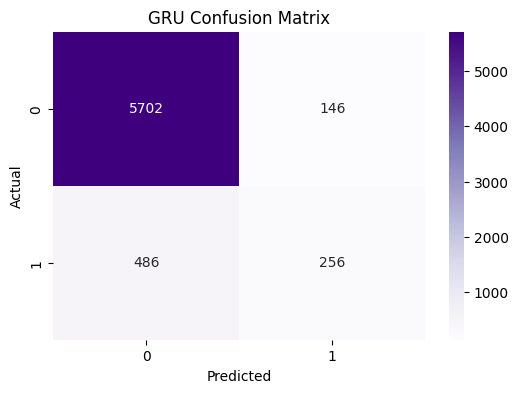


GRU Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5848
           1       0.64      0.35      0.45       742

    accuracy                           0.90      6590
   macro avg       0.78      0.66      0.70      6590
weighted avg       0.89      0.90      0.89      6590



In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

val_pred_gru = (model_gru.predict(X_val_lstm) >= 0.5).astype(int)

cm_gru = confusion_matrix(y_val, val_pred_gru)

plt.figure(figsize=(6,4))
sns.heatmap(cm_gru, annot=True, fmt="d", cmap="Purples")
plt.title("GRU Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nGRU Classification Report:\n")
print(classification_report(y_val, val_pred_gru))

11.3 GRU Accuracy curve

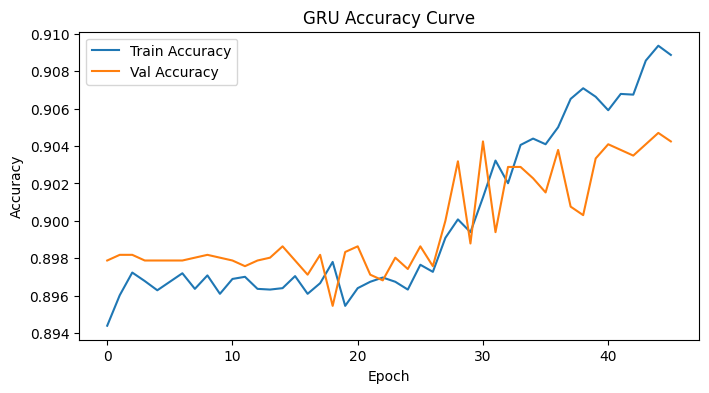

In [45]:
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title("GRU Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

11.4 GRU Loss Curve

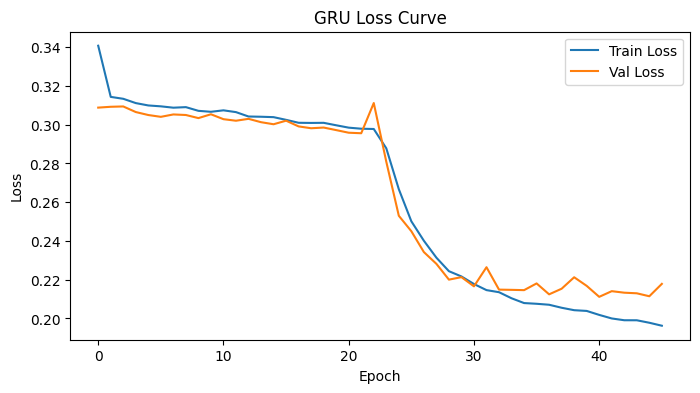

In [46]:
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title("GRU Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### __=================Multiple Hybrid Model=================__

### 12. Hybrid ANN + CNN Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop_hybrid = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_hybrid = Sequential([
    # CNN feature extraction
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),

    # ANN layers
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),

    # Output
    Dense(1, activation='sigmoid')
])

model_hybrid.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_hybrid.summary()

history_hybrid = model_hybrid.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_hybrid],
    verbose=1
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 46, 32)            128       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 23, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 64)            6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                                 
 dense_13 (Dense)            (None, 128)              

12.1 Evaluate Hybrid Model

In [47]:
hyb_loss, hyb_acc = model_hybrid.evaluate(X_val_cnn, y_val, verbose=0)
print(f"\nHybrid ANN+CNN Accuracy: {hyb_acc:.4f}")
print(f"Hybrid ANN+CNN Loss: {hyb_loss:.4f}")


Hybrid ANN+CNN Accuracy: 0.9082
Hybrid ANN+CNN Loss: 0.2083


12.2 ann + cnn Confusion Matrix

206/206 [==============================] - 1s 2ms/step


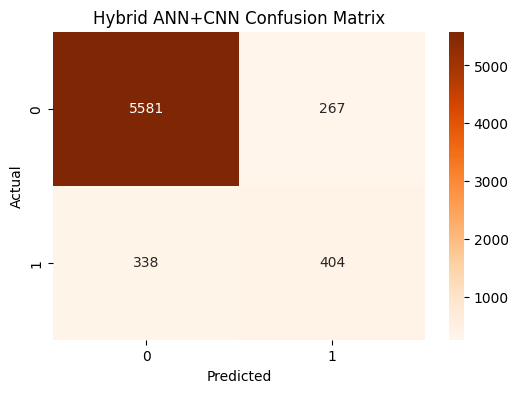


Hybrid Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5848
           1       0.60      0.54      0.57       742

    accuracy                           0.91      6590
   macro avg       0.77      0.75      0.76      6590
weighted avg       0.90      0.91      0.91      6590



In [48]:
val_pred_hyb = (model_hybrid.predict(X_val_cnn) >= 0.5).astype(int)

cm_hyb = confusion_matrix(y_val, val_pred_hyb)

plt.figure(figsize=(6,4))
sns.heatmap(cm_hyb, annot=True, fmt="d", cmap="Oranges")
plt.title("Hybrid ANN+CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nHybrid Classification Report:\n")
print(classification_report(y_val, val_pred_hyb))


12.3 Hybrid Accuracy Graph

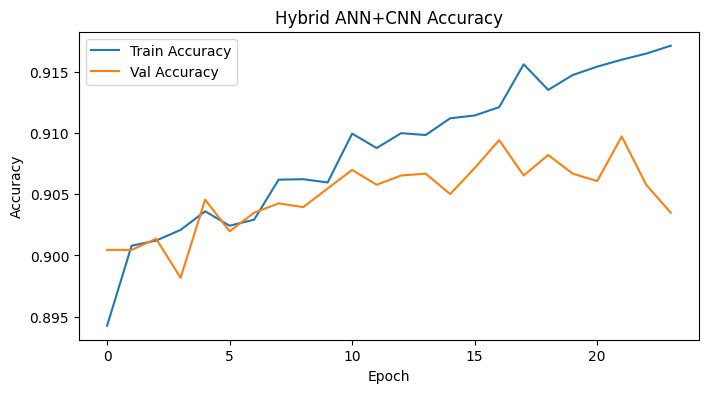

In [49]:
plt.figure(figsize=(8,4))
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Val Accuracy')
plt.title("Hybrid ANN+CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


12.4 Hybrid Loss Graph

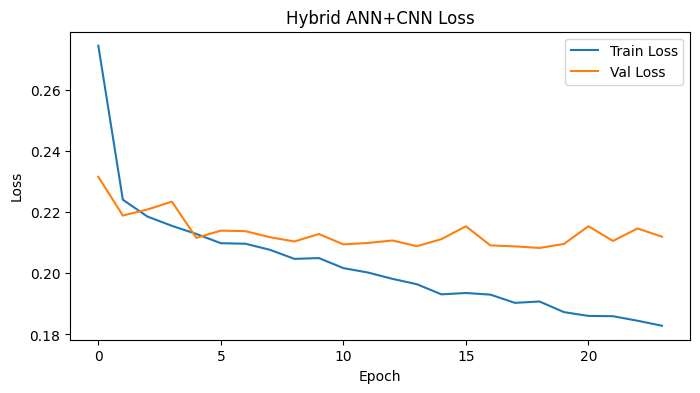

In [50]:
plt.figure(figsize=(8,4))
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Val Loss')
plt.title("Hybrid ANN+CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 13 Hybrid CNN + LSTM

In [17]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop_cnn_lstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_cnn_lstm = Sequential([
    # CNN feature extraction
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # LSTM layer
    LSTM(64),

    # Dense (ANN) layers
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model_cnn_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model_cnn_lstm.summary()

history_cnn_lstm = model_cnn_lstm.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn_lstm],
    verbose=1
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 46, 32)            128       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 23, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 21, 64)            6208      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_17 (Dense)            (None, 64)               

13.1 Evaluation CNN+LSTM

In [51]:
cnn_lstm_loss, cnn_lstm_acc = model_cnn_lstm.evaluate(X_val_cnn, y_val, verbose=0)
print(f"\nCNN+LSTM Accuracy: {cnn_lstm_acc:.4f}")
print(f"CNN+LSTM Loss: {cnn_lstm_loss:.4f}")


CNN+LSTM Accuracy: 0.9052
CNN+LSTM Loss: 0.2096


13.2 Confusion Matrix CNN+LSTM

206/206 [==============================] - 1s 3ms/step


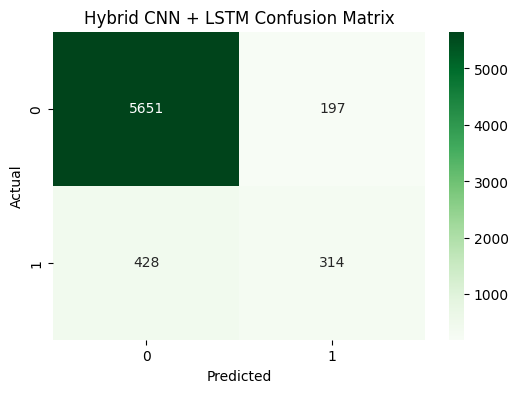


CNN+LSTM Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5848
           1       0.61      0.42      0.50       742

    accuracy                           0.91      6590
   macro avg       0.77      0.69      0.72      6590
weighted avg       0.89      0.91      0.90      6590



In [52]:
val_pred_cnn_lstm = (model_cnn_lstm.predict(X_val_cnn) >= 0.5).astype(int)

cm_cnn_lstm = confusion_matrix(y_val, val_pred_cnn_lstm)

plt.figure(figsize=(6,4))
sns.heatmap(cm_cnn_lstm, annot=True, fmt="d", cmap="Greens")
plt.title("Hybrid CNN + LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nCNN+LSTM Classification Report:\n")
print(classification_report(y_val, val_pred_cnn_lstm))


13.3 Accuracy Curve CNN+LSTM

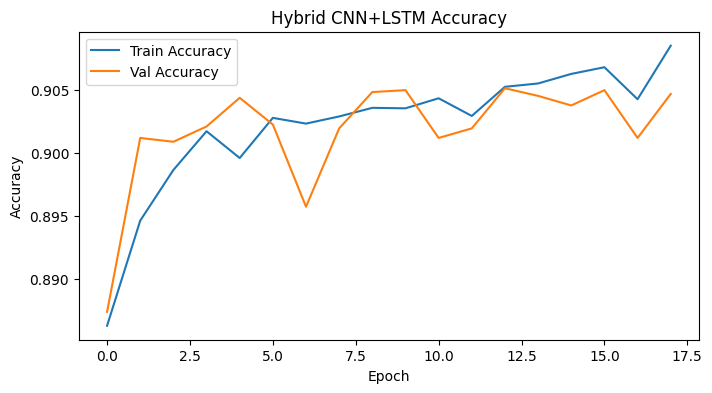

In [53]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title("Hybrid CNN+LSTM Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


13.4 Loss Curve CNN+LSTM

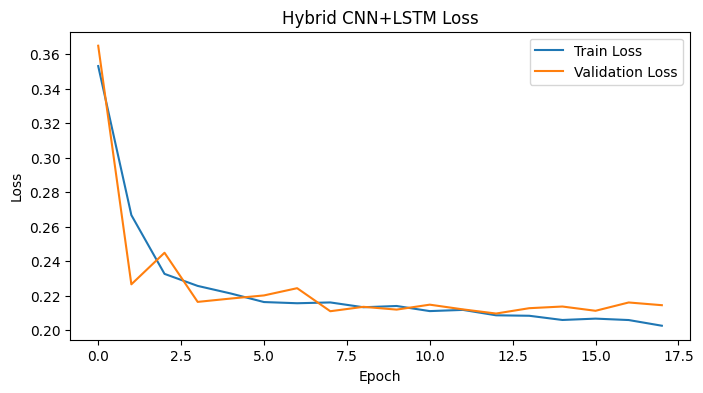

In [54]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn_lstm.history['loss'], label='Train Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.title("Hybrid CNN+LSTM Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


### 14. Hybrid CNN+GRU

In [22]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop_cnn_gru = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_cnn_gru = Sequential([
    # CNN feature extraction
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # GRU layer
    GRU(64),

    # Dense (ANN) layers
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model_cnn_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_cnn_gru.summary()

history_cnn_gru = model_cnn_gru.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn_gru],
    verbose=1
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 46, 32)            128       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 23, 32)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 21, 64)            6208      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_20 (Dense)            (None, 64)               

14.1 Evaluation CNN+GRU

In [55]:
cnn_gru_loss, cnn_gru_acc = model_cnn_gru.evaluate(X_val_cnn, y_val, verbose=0)
print(f"\nCNN+GRU Accuracy: {cnn_gru_acc:.4f}")
print(f"CNN+GRU Loss: {cnn_gru_loss:.4f}")



CNN+GRU Accuracy: 0.9102
CNN+GRU Loss: 0.2051


14.2 Confusion Matrix CNN+GRU

206/206 [==============================] - 1s 3ms/step


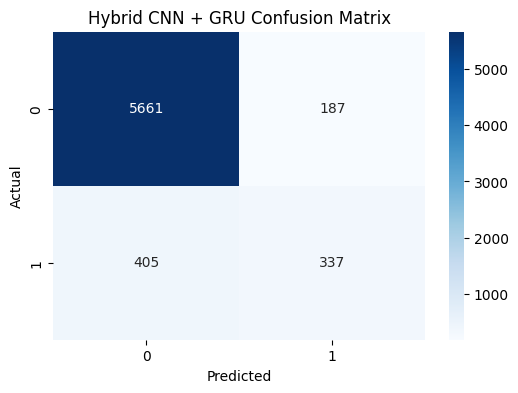


CNN+GRU Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5848
           1       0.64      0.45      0.53       742

    accuracy                           0.91      6590
   macro avg       0.79      0.71      0.74      6590
weighted avg       0.90      0.91      0.90      6590



In [56]:
val_pred_cnn_gru = (model_cnn_gru.predict(X_val_cnn) >= 0.5).astype(int)

cm_cnn_gru = confusion_matrix(y_val, val_pred_cnn_gru)

plt.figure(figsize=(6,4))
sns.heatmap(cm_cnn_gru, annot=True, fmt="d", cmap="Blues")
plt.title("Hybrid CNN + GRU Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nCNN+GRU Classification Report:\n")
print(classification_report(y_val, val_pred_cnn_gru))


14.3 Accuracy Curve CNN+GRU

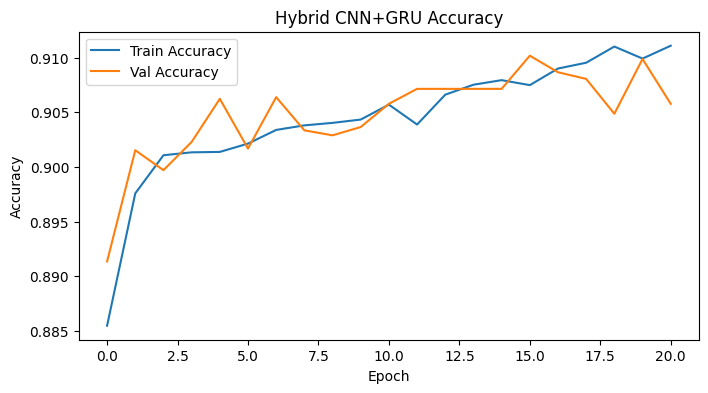

In [25]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_gru.history['val_accuracy'], label='Val Accuracy')
plt.title("Hybrid CNN+GRU Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


14.4 Loss Curve CNN+GRU

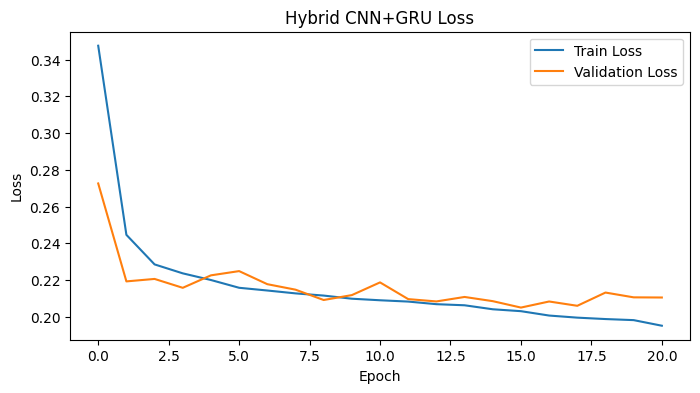

In [26]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn_gru.history['loss'], label='Train Loss')
plt.plot(history_cnn_gru.history['val_loss'], label='Validation Loss')
plt.title("Hybrid CNN+GRU Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


### 15. Hybrid ANN + GRU

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop_ann_gru = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_ann_gru = Sequential([
    # GRU layer (sequence feature extraction)
    GRU(64, return_sequences=False, input_shape=(input_dim, 1)),
    Dropout(0.3),

    # ANN layers
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(16, activation='relu'),

    # Output
    Dense(1, activation='sigmoid')
])

model_ann_gru.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_ann_gru.summary()

history_ann_gru = model_ann_gru.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_ann_gru],
    verbose=1
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                12864     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 16)               

15.1 Evaluation ANN+GRU

In [28]:
ann_gru_loss, ann_gru_acc = model_ann_gru.evaluate(X_val_lstm, y_val, verbose=0)
print(f"\nANN+GRU Accuracy: {ann_gru_acc:.4f}")
print(f"ANN+GRU Loss: {ann_gru_loss:.4f}")



ANN+GRU Accuracy: 0.9012
ANN+GRU Loss: 0.2023


15.2 Confusion Matrix ANN+GRU

206/206 [==============================] - 1s 4ms/step


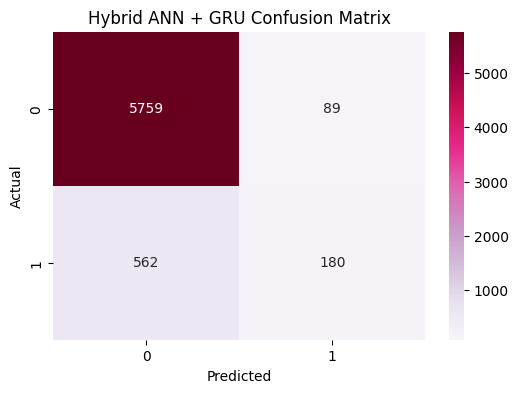


ANN+GRU Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5848
           1       0.67      0.24      0.36       742

    accuracy                           0.90      6590
   macro avg       0.79      0.61      0.65      6590
weighted avg       0.88      0.90      0.88      6590



In [29]:
val_pred_ann_gru = (model_ann_gru.predict(X_val_lstm) >= 0.5).astype(int)

cm_ann_gru = confusion_matrix(y_val, val_pred_ann_gru)

plt.figure(figsize=(6,4))
sns.heatmap(cm_ann_gru, annot=True, fmt="d", cmap="PuRd")
plt.title("Hybrid ANN + GRU Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nANN+GRU Classification Report:\n")
print(classification_report(y_val, val_pred_ann_gru))


15.3 Accuracy Curve ANN+GRU

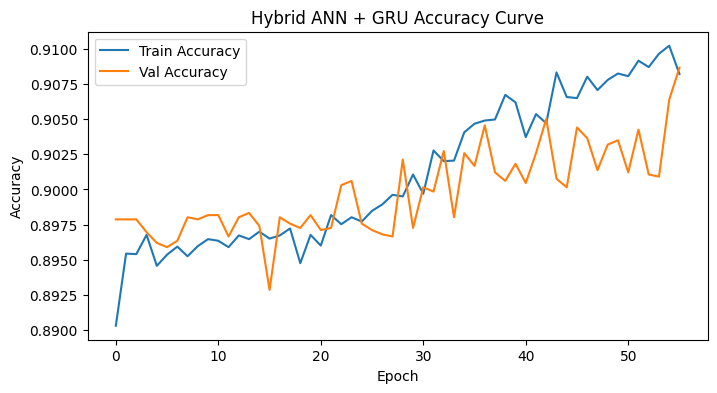

In [30]:
plt.figure(figsize=(8,4))
plt.plot(history_ann_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann_gru.history['val_accuracy'], label='Val Accuracy')
plt.title("Hybrid ANN + GRU Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


15.4 Loss Curve ANN+GRU

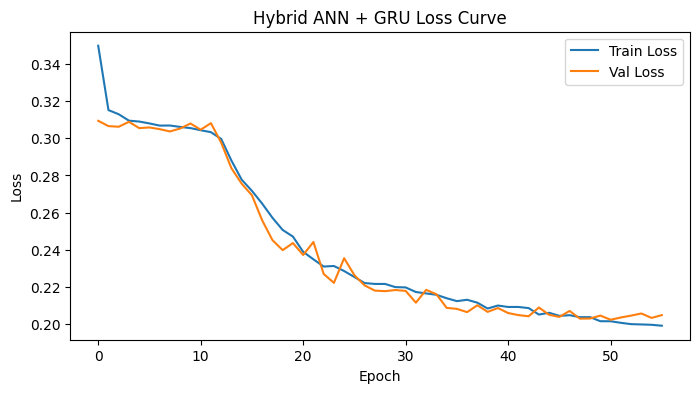

In [31]:
plt.figure(figsize=(8,4))
plt.plot(history_ann_gru.history['loss'], label='Train Loss')
plt.plot(history_ann_gru.history['val_loss'], label='Val Loss')
plt.title("Hybrid ANN + GRU Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


### 16. Compare Between (ANN, CNN, LSTM, GRU, ANN+CNN, CNN+LSTM, CNN+GRU, ANN+GRU)

In [ ]:
import pandas as pd

data = {
    "Model": [
        "ANN",
        "CNN",
        "LSTM",
        "GRU",
        "Hybrid ANN+CNN",
        "Hybrid CNN+LSTM",
        "Hybrid CNN+GRU",
        "Hybrid ANN+GRU",
    ],
    
    "Training Accuracy": [
        history_ann.history['accuracy'][-1],
        history_cnn.history['accuracy'][-1],
        history_lstm.history['accuracy'][-1],
        history_gru.history['accuracy'][-1],
        history_hybrid.history['accuracy'][-1],
        history_cnn_lstm.history['accuracy'][-1],
        history_cnn_gru.history['accuracy'][-1],
        history_ann_gru.history['accuracy'][-1],
    ],
    
    "Validation Accuracy": [
        history_ann.history['val_accuracy'][-1],
        history_cnn.history['val_accuracy'][-1],
        history_lstm.history['val_accuracy'][-1],
        history_gru.history['val_accuracy'][-1],
        history_hybrid.history['val_accuracy'][-1],
        history_cnn_lstm.history['val_accuracy'][-1],
        history_cnn_gru.history['val_accuracy'][-1],
        history_ann_gru.history['val_accuracy'][-1],
    ],
    
    "Test Accuracy": [
        ann_loss,
        cnn_loss,
        lstm_loss,
        gru_loss,
        hyb_loss,
        cnn_lstm_loss,
        cnn_gru_loss,
        ann_gru_loss,
    ]
}

df_results = pd.DataFrame(data)

def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: #06B6D4; color: white' if v else '' for v in is_max]

styled_df = df_results.style.apply(highlight_best, subset=["Training Accuracy", "Validation Accuracy", "Validation Loss"])

styled_df

,Model,Training Accuracy,Validation Accuracy,Validation Loss
0,ANN,0.919803,0.905766,0.203192
1,CNN,0.913316,0.906525,0.204001
2,LSTM,0.894196,0.896965,0.256243
3,GRU,0.908877,0.904249,0.211169
4,Hybrid ANN+CNN,0.917109,0.903490,0.208331
5,Hybrid CNN+LSTM,0.908536,0.904704,0.209616
6,Hybrid CNN+GRU,0.911077,0.905766,0.205057
7,Hybrid ANN+GRU,0.908194,0.908649,0.202311


### 17. Comparison With All Model

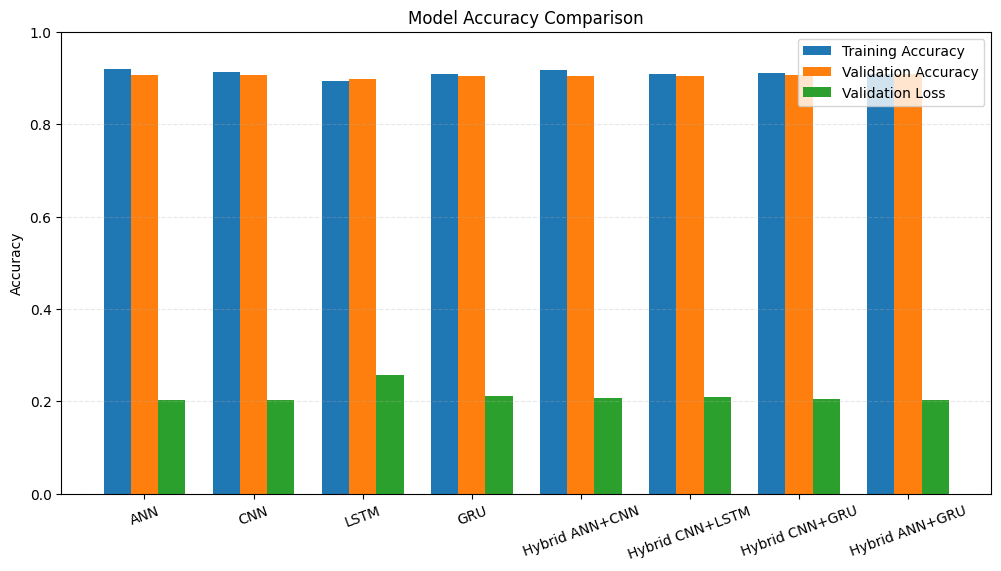

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = df_results["Model"].values

# Accuracy values
train_acc = df_results["Training Accuracy"].values
val_acc   = df_results["Validation Accuracy"].values
val_los  = df_results["Validation Loss"].values

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(12, 6))

plt.bar(x - width, train_acc, width, label="Training Accuracy")
plt.bar(x, val_acc, width, label="Validation Accuracy")
plt.bar(x + width, val_los, width, label="Validation Loss")

plt.xticks(x, models, rotation=20)
plt.ylim(0.00, 1.00)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()
